# Steering Analysis Results: Statistical Significance Testing

This notebook analyzes all human-model comparison metrics from the comprehensive steering experiments, calculating p-values and statistical significance for model performance differences.

## Overview:
- **Data Source**: JSON metrics files from `outputs/feature_classification/metrics/`
- **Statistical Tests**: Binomial tests for accuracy, confidence intervals for correlations
- **Output**: Comprehensive table with p-values and significance indicators

In [9]:
# Import Required Libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# Load Steering Analysis Files
analysis_dir = Path('../outputs/feature_classification/comprehensive_analysis')
print(f"Looking for steering analysis files in: {analysis_dir.absolute()}")

# Find all steering analysis JSON files (exclude feature_usage files and comprehensive summary)
all_steering_files = [f for f in analysis_dir.glob('*steering_analysis*.json') 
                     if '_feature_usage' not in f.name and 'comprehensive_steering_analysis_summary' not in f.name]

print(f"Found {len(all_steering_files)} steering analysis files (including old format):")
for f in sorted(all_steering_files):
    print(f"  - {f.name}")

# Filter out old format files by checking if they have the new structure
steering_files = []
print(f"\nChecking file formats...")

for file in all_steering_files:
    try:
        with file.open('r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Check if file has new structure with sae_adapter and sae_regular
        if 'sae_adapter' in data and 'sae_regular' in data:
            steering_files.append(file)
            print(f"  ✅ {file.name} - New format (has sae_adapter and sae_regular)")
        else:
            print(f"  ⚠️  {file.name} - Old format (missing sae_adapter/sae_regular) - SKIPPING")
    except Exception as e:
        print(f"  ❌ {file.name} - Error reading file: {e} - SKIPPING")

print(f"\n📊 Using {len(steering_files)} files with new format:")
for f in sorted(steering_files):
    print(f"  - {f.name}")

# Find SAE feature usage files
sae_feature_usage_files = [f for f in analysis_dir.glob('*_sae_feature_usage.json')]
print(f"\nFound {len(sae_feature_usage_files)} SAE feature usage files:")
for f in sorted(sae_feature_usage_files):
    print(f"  - {f.name}")

# Find adapter feature usage files  
adapter_feature_usage_files = [f for f in analysis_dir.glob('*_adapter_feature_usage.json')]
print(f"\nFound {len(adapter_feature_usage_files)} adapter feature usage files:")
for f in sorted(adapter_feature_usage_files):
    print(f"  - {f.name}")

if not steering_files:
    print("\n⚠️  No NEW FORMAT steering analysis files found! Make sure to run the updated steering analysis experiments.")
    print("   Run: python src/fsrl/scripts/alignment_steering_analysis.py --run_all_experiments")
else:
    print(f"\n✅ Ready to analyze {len(steering_files)} NEW FORMAT steering experiment results!")
    print(f"✅ Ready to analyze {len(sae_feature_usage_files)} SAE feature usage files!")
    print(f"✅ Ready to analyze {len(adapter_feature_usage_files)} adapter feature usage files!")

Looking for steering analysis files in: /home/jazhyc/projects/FSRL/feature-steering-RL/notebooks/../outputs/feature_classification/comprehensive_analysis
Found 12 steering analysis files (including old format):
  - alignment_steering_analysis_prompt_chosen.json
  - alignment_steering_analysis_prompt_chosen_ignore_mask.json
  - alignment_steering_analysis_prompt_only.json
  - alignment_steering_analysis_prompt_only_ignore_mask.json
  - alignment_steering_analysis_prompt_rejected.json
  - alignment_steering_analysis_prompt_rejected_ignore_mask.json
  - formatting_steering_analysis_prompt_chosen.json
  - formatting_steering_analysis_prompt_chosen_ignore_mask.json
  - formatting_steering_analysis_prompt_only.json
  - formatting_steering_analysis_prompt_only_ignore_mask.json
  - formatting_steering_analysis_prompt_rejected.json
  - formatting_steering_analysis_prompt_rejected_ignore_mask.json

Checking file formats...
  ✅ formatting_steering_analysis_prompt_only_ignore_mask.json - New forma

In [20]:
# Parse and Structure Steering Analysis Data
all_results = []

def load_feature_usage_data(feature_usage_file):
    """Load and extract key stats from feature usage file."""
    try:
        with feature_usage_file.open('r', encoding='utf-8') as f:
            usage_data = json.load(f)
        
        summary = usage_data.get('summary', {})
        feature_details = usage_data.get('feature_usage_details', [])
        
        # Calculate related feature statistics
        related_features = [f for f in feature_details if f.get('classification') == 'related' and f.get('usage_count', 0) > 0]
        not_related_features = [f for f in feature_details if f.get('classification') == 'not-related' and f.get('usage_count', 0) > 0]
        active_features = [f for f in feature_details if f.get('usage_count', 0) > 0]
        
        total_related_usage = sum(f.get('usage_count', 0) for f in related_features)
        total_not_related_usage = sum(f.get('usage_count', 0) for f in not_related_features)
        total_classified_usage = total_related_usage + total_not_related_usage
        
        related_usage_rate = total_related_usage / total_classified_usage if total_classified_usage > 0 else 0
        
        return {
            'total_active_features': len(active_features),
            'related_active_features': len(related_features),
            'not_related_active_features': len(not_related_features),
            'related_usage_rate': related_usage_rate,
            'total_usage_events': summary.get('total_usage_events', 0),
            'analysis_type': summary.get('analysis_type', 'unknown')
        }
    except Exception as e:
        print(f"Error loading feature usage file {feature_usage_file.name}: {e}")
        return None

for analysis_file in steering_files:
    try:
        with analysis_file.open('r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Check if this file has the new structure (both sae_adapter and sae_regular)
        if 'sae_adapter' not in data or 'sae_regular' not in data:
            print(f"Skipping old format file: {analysis_file.name}")
            continue
        
        # Extract key information from filename
        filename = analysis_file.stem
        # Expected format: "MODE_steering_analysis_RESPONSE_TYPE_ignore_mask"
        # e.g., "alignment_steering_analysis_prompt_chosen_ignore_mask"
        
        parts = filename.split('_')
        if len(parts) >= 3:
            mode = parts[0]  # alignment, formatting
            
            # Extract response type
            if 'prompt_only' in filename:
                response_type = 'prompt_only'
            elif 'prompt_chosen' in filename:
                response_type = 'prompt_chosen'
            elif 'prompt_rejected' in filename:
                response_type = 'prompt_rejected'
            else:
                response_type = 'unknown'
            
            # Check if ignore_mask is used
            ignore_mask = 'ignore_mask' in filename
        else:
            mode = 'unknown'
            response_type = 'unknown'
            ignore_mask = False
        
        # Extract configuration info
        config = data.get('configuration', {})
        
        # Get adapter results (new structure)
        adapter_data = data.get('sae_adapter', {})
        sae_data = data.get('sae_regular', {})
        
        # Verify that both have required fields
        required_fields = ['total_steered_features', 'related_steered', 'steering_related_rate', 'baseline_related_rate']
        if not all(field in adapter_data for field in required_fields) or not all(field in sae_data for field in required_fields):
            print(f"Skipping incomplete data file: {analysis_file.name}")
            continue
        
        # Load corresponding feature usage files
        base_name = filename
        adapter_usage_file = analysis_dir / f"{base_name}_adapter_feature_usage.json"
        sae_usage_file = analysis_dir / f"{base_name}_sae_feature_usage.json"
        
        adapter_usage_stats = load_feature_usage_data(adapter_usage_file) if adapter_usage_file.exists() else None
        sae_usage_stats = load_feature_usage_data(sae_usage_file) if sae_usage_file.exists() else None
        
        # Structure the steering analysis data with both adapter and SAE results
        analysis_record = {
            'filename': filename,
            'mode': mode,
            'response_type': response_type,
            'ignore_mask': ignore_mask,
            'append_response': config.get('append_response'),
            'classification_mode': config.get('classification_mode', mode),
            
            # Adapter results (steering)
            'adapter_total_steered_features': adapter_data.get('total_steered_features', 0),
            'adapter_related_steered': adapter_data.get('related_steered', 0),
            'adapter_not_related_steered': adapter_data.get('not_related_steered', 0),
            'adapter_total_positions_analyzed': adapter_data.get('total_positions_analyzed', 0),
            'adapter_mean_steered_per_position': adapter_data.get('mean_steered_per_position', 0),
            'adapter_baseline_related_rate': adapter_data.get('baseline_related_rate', 0),
            'adapter_steering_related_rate': adapter_data.get('steering_related_rate', 0),
            'adapter_improvement_over_baseline': adapter_data.get('improvement_over_baseline', 0),
            'adapter_l0_norm_mean': adapter_data.get('l0_norm_mean', 0),
            'adapter_l0_norm_std': adapter_data.get('l0_norm_std', 0),
            'adapter_l0_norm_stderr': adapter_data.get('l0_norm_stderr', 0),
            
            # SAE results (baseline)
            'sae_total_active_features': sae_data.get('total_steered_features', 0),
            'sae_related_active': sae_data.get('related_steered', 0),
            'sae_not_related_active': sae_data.get('not_related_steered', 0),
            'sae_total_positions_analyzed': sae_data.get('total_positions_analyzed', 0),
            'sae_mean_active_per_position': sae_data.get('mean_steered_per_position', 0),
            'sae_baseline_related_rate': sae_data.get('baseline_related_rate', 0),
            'sae_related_rate': sae_data.get('steering_related_rate', 0),  # This is the SAE's natural rate
            'sae_improvement_over_theoretical': sae_data.get('improvement_over_baseline', 0),
            'sae_l0_norm_mean': sae_data.get('l0_norm_mean', 0),
            'sae_l0_norm_std': sae_data.get('l0_norm_std', 0),
            'sae_l0_norm_stderr': sae_data.get('l0_norm_stderr', 0),
            
            # Feature usage statistics
            'adapter_usage_stats': adapter_usage_stats,
            'sae_usage_stats': sae_usage_stats,
            
            # Calculate improvement of adapter over SAE (new baseline)
            'improvement_over_sae': (adapter_data.get('steering_related_rate', 0) - 
                                   sae_data.get('steering_related_rate', 0))
        }
        all_results.append(analysis_record)
        print(f"✅ Loaded new format file: {analysis_file.name}")
        
    except Exception as e:
        print(f"❌ Error processing {analysis_file.name}: {e}")

# Create DataFrame
df = pd.DataFrame(all_results)
print(f"\nLoaded {len(df)} steering analysis results with adapter and SAE data (new format only):")
if len(df) > 0:
    print(f"Modes: {df['mode'].value_counts().to_dict()}")
    print(f"Response types: {df['response_type'].value_counts().to_dict()}")
    print(f"Ignore mask usage: {df['ignore_mask'].value_counts().to_dict()}")
    print(f"Adapter improvement over theoretical baseline: {df['adapter_improvement_over_baseline'].min():.3f} - {df['adapter_improvement_over_baseline'].max():.3f}")
    print(f"SAE improvement over theoretical baseline: {df['sae_improvement_over_theoretical'].min():.3f} - {df['sae_improvement_over_theoretical'].max():.3f}")
    print(f"Adapter improvement over SAE baseline: {df['improvement_over_sae'].min():.3f} - {df['improvement_over_sae'].max():.3f}")
    
    # Show some examples of the new structure
    print(f"\nSample adapter vs SAE rates:")
    for i in range(min(3, len(df))):
        row = df.iloc[i]
        print(f"  {row['mode']}-{row['response_type']}:")
        print(f"    Theoretical baseline: {row['adapter_baseline_related_rate']:.3f}")
        print(f"    SAE rate (new baseline): {row['sae_related_rate']:.3f}")
        print(f"    Adapter rate: {row['adapter_steering_related_rate']:.3f}")
        print(f"    Improvement over SAE: {row['improvement_over_sae']:.3f}")
    
# Display first few rows with key columns
print("\nFirst few records (key columns):")
key_columns = ['mode', 'response_type', 'ignore_mask', 'adapter_baseline_related_rate', 
               'sae_related_rate', 'adapter_steering_related_rate', 'improvement_over_sae']
display(df[key_columns].head())

✅ Loaded new format file: formatting_steering_analysis_prompt_only_ignore_mask.json
✅ Loaded new format file: formatting_steering_analysis_prompt_rejected_ignore_mask.json
✅ Loaded new format file: formatting_steering_analysis_prompt_rejected_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_rejected_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_rejected_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_only_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_only_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_chosen_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_chosen_ignore_mask.json
✅ Loaded new format file: formatting_steering_analysis_prompt_chosen_ignore_mask.json

Loaded 6 steering analysis results with adapter and SAE data (new format only):
Modes: {'formatting': 3, 'alignment': 3}
Response types: {'prom

,mode,response_type,ignore_mask,adapter_baseline_related_rate,sae_related_rate,adapter_steering_related_rate,improvement_over_sae
0,formatting,prompt_only,True,0.235538,0.252453,0.257280,0.004827
1,formatting,prompt_reje...,True,0.235538,0.245116,0.255189,0.010073
2,alignment,prompt_reje...,True,0.170528,0.175337,0.156384,-0.018954
3,alignment,prompt_only,True,0.170528,0.170957,0.161608,-0.009349
4,alignment,prompt_chosen,True,0.170528,0.175866,0.159308,-0.016559


In [12]:
# Calculate Statistical Tests for Steering Analysis (Adapter vs SAE)
def calculate_adapter_vs_sae_significance(adapter_rate, sae_rate, n_positions, confidence=0.95):
    """Calculate confidence interval and p-value for adapter improvement over SAE using binomial test."""
    if n_positions <= 0:
        return None, None, None, None
    
    improvement = adapter_rate - sae_rate
    
    # For confidence intervals, use normal approximation for difference of proportions
    adapter_var = adapter_rate * (1 - adapter_rate) / n_positions
    sae_var = sae_rate * (1 - sae_rate) / n_positions
    se_diff = np.sqrt(adapter_var + sae_var)
    
    alpha = 1 - confidence
    z_crit = norm.ppf(1 - alpha/2)
    ci_lower = improvement - z_crit * se_diff
    ci_upper = improvement + z_crit * se_diff
    
    # Use exact binomial test for p-value
    # Test if adapter rate is significantly different from SAE rate
    adapter_successes = int(round(adapter_rate * n_positions))
    
    # Perform two-tailed binomial test
    # H0: true adapter rate equals SAE rate (null hypothesis: no difference)
    # H1: true adapter rate != SAE rate
    try:
        from scipy.stats import binomtest
        binom_result = binomtest(adapter_successes, n_positions, sae_rate, alternative='two-sided')
        p_value = binom_result.pvalue
    except ImportError:
        # Fallback to older scipy versions
        from scipy.stats import binom_test
        p_value = binom_test(adapter_successes, n_positions, sae_rate, alternative='two-sided')
    
    return improvement, ci_lower, ci_upper, p_value

def steering_significance_level(p_value):
    """Convert p-value to significance symbols."""
    if p_value is None or pd.isna(p_value):
        return ''
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Apply statistical tests comparing adapter vs SAE
df['adapter_vs_sae_ci_lower'] = None
df['adapter_vs_sae_ci_upper'] = None
df['adapter_vs_sae_pvalue'] = None

for idx, row in df.iterrows():
    improvement, ci_lower, ci_upper, p_value = calculate_adapter_vs_sae_significance(
        row['adapter_steering_related_rate'], 
        row['sae_related_rate'], 
        row['adapter_total_positions_analyzed']  # Use adapter positions since that's what we're testing
    )
    df.at[idx, 'adapter_vs_sae_ci_lower'] = ci_lower
    df.at[idx, 'adapter_vs_sae_ci_upper'] = ci_upper
    df.at[idx, 'adapter_vs_sae_pvalue'] = p_value

# Add significance indicators
df['adapter_vs_sae_sig'] = df['adapter_vs_sae_pvalue'].apply(steering_significance_level)
df['positive_vs_sae'] = df['improvement_over_sae'].apply(lambda x: '✓' if x > 0 else '✗')

print("Statistical tests completed (Adapter vs SAE)!")
print(f"Significant improvements over SAE: {(df['adapter_vs_sae_sig'] != '').sum()}/{len(df)}")
print(f"Positive improvements over SAE: {(df['positive_vs_sae'] == '✓').sum()}/{len(df)}")
print(f"Mean improvement over SAE: {df['improvement_over_sae'].mean():.4f}")
print(f"Best improvement over SAE: {df['improvement_over_sae'].max():.4f}")

# Also keep the original theoretical baseline tests for comparison
df['improvement_ci_lower'] = None
df['improvement_ci_upper'] = None
df['improvement_pvalue'] = None

def calculate_improvement_significance(baseline_rate, steering_rate, n_positions, confidence=0.95):
    """Calculate confidence interval and p-value for improvement over theoretical baseline using binomial test."""
    if n_positions <= 0:
        return None, None, None, None
    
    improvement = steering_rate - baseline_rate
    
    # For confidence intervals, still use normal approximation (widely accepted)
    baseline_var = baseline_rate * (1 - baseline_rate) / n_positions
    steering_var = steering_rate * (1 - steering_rate) / n_positions
    se_diff = np.sqrt(baseline_var + steering_var)
    
    alpha = 1 - confidence
    z_crit = norm.ppf(1 - alpha/2)
    ci_lower = improvement - z_crit * se_diff
    ci_upper = improvement + z_crit * se_diff
    
    # Use exact binomial test for p-value
    steering_successes = int(round(steering_rate * n_positions))
    
    try:
        from scipy.stats import binomtest
        binom_result = binomtest(steering_successes, n_positions, baseline_rate, alternative='two-sided')
        p_value = binom_result.pvalue
    except ImportError:
        from scipy.stats import binom_test
        p_value = binom_test(steering_successes, n_positions, baseline_rate, alternative='two-sided')
    
    return improvement, ci_lower, ci_upper, p_value

for idx, row in df.iterrows():
    improvement, ci_lower, ci_upper, p_value = calculate_improvement_significance(
        row['adapter_baseline_related_rate'], 
        row['adapter_steering_related_rate'], 
        row['adapter_total_positions_analyzed']
    )
    df.at[idx, 'improvement_ci_lower'] = ci_lower
    df.at[idx, 'improvement_ci_upper'] = ci_upper
    df.at[idx, 'improvement_pvalue'] = p_value

df['improvement_sig'] = df['improvement_pvalue'].apply(steering_significance_level)
df['positive_improvement'] = df['adapter_improvement_over_baseline'].apply(lambda x: '✓' if x > 0 else '✗')

print(f"\nComparison of statistical tests:")
print(f"Significant vs theoretical baseline: {(df['improvement_sig'] != '').sum()}/{len(df)}")
print(f"Significant vs SAE baseline: {(df['adapter_vs_sae_sig'] != '').sum()}/{len(df)}")
print(f"Mean improvement vs theoretical: {df['adapter_improvement_over_baseline'].mean():.4f}")
print(f"Mean improvement vs SAE: {df['improvement_over_sae'].mean():.4f}")

Statistical tests completed (Adapter vs SAE)!
Significant improvements over SAE: 6/6
Positive improvements over SAE: 3/6
Mean improvement over SAE: -0.0038
Best improvement over SAE: 0.0101

Comparison of statistical tests:
Significant vs theoretical baseline: 6/6
Significant vs SAE baseline: 6/6
Mean improvement vs theoretical: 0.0038
Mean improvement vs SAE: -0.0038


In [13]:
# Create Comprehensive Steering Results Table (Adapter vs SAE Baseline)
def format_number(x, decimals=3):
    """Format number for display."""
    if pd.isna(x) or x is None:
        return 'N/A'
    return f'{x:.{decimals}f}'

def format_ci(lower, upper, decimals=3):
    """Format confidence interval for display."""
    if pd.isna(lower) or pd.isna(upper) or lower is None or upper is None:
        return 'N/A'
    return f'[{lower:.{decimals}f}, {upper:.{decimals}f}]'

def format_percentage(x, decimals=1):
    """Format as percentage."""
    if pd.isna(x) or x is None:
        return 'N/A'
    return f'{x*100:.{decimals}f}%'

# Prepare display table
results_table = df.copy()
results_table = results_table.sort_values(['mode', 'response_type', 'improvement_over_sae'], ascending=[True, True, False])

# Create formatted columns using SAE as baseline
results_table['SAE Baseline Rate'] = results_table['sae_related_rate'].apply(lambda x: format_percentage(x, 1))
results_table['Adapter Rate'] = results_table['adapter_steering_related_rate'].apply(lambda x: format_percentage(x, 1))
results_table['Improvement over SAE'] = results_table['improvement_over_sae'].apply(lambda x: format_number(x, 4)) + ' ' + results_table['adapter_vs_sae_sig'] + ' ' + results_table['positive_vs_sae']
results_table['Improvement p-value'] = results_table['adapter_vs_sae_pvalue'].apply(lambda x: format_number(x, 4) if x is not None else 'N/A')
results_table['Improvement 95% CI'] = results_table.apply(lambda row: format_ci(row['adapter_vs_sae_ci_lower'], row['adapter_vs_sae_ci_upper'], 4), axis=1)
results_table['Adapter L0 Norm'] = results_table['adapter_l0_norm_mean'].apply(lambda x: format_number(x, 2))
results_table['SAE L0 Norm'] = results_table['sae_l0_norm_mean'].apply(lambda x: format_number(x, 2))
results_table['Adapter Features'] = results_table['adapter_total_steered_features'].astype(int).astype(str)
results_table['SAE Features'] = results_table['sae_total_active_features'].astype(int).astype(str)
results_table['Adapter Related/Total'] = results_table['adapter_related_steered'].astype(str) + '/' + results_table['adapter_total_steered_features'].astype(str)
results_table['SAE Related/Total'] = results_table['sae_related_active'].astype(str) + '/' + results_table['sae_total_active_features'].astype(str)

# Select columns for display
display_columns = [
    'mode', 'response_type', 'ignore_mask', 'SAE Baseline Rate', 'Adapter Rate', 
    'Improvement over SAE', 'Improvement p-value', 'Improvement 95% CI', 
    'Adapter L0 Norm', 'SAE L0 Norm', 'Adapter Related/Total', 'SAE Related/Total'
]

final_table = results_table[display_columns].copy()
final_table.columns = ['Mode', 'Response', 'Ignore Mask', 'SAE Baseline %', 'Adapter %', 
                      'Improvement', 'p-value', '95% CI', 'Adapter L0', 'SAE L0', 
                      'Adapter R/T', 'SAE R/T']

print("🎯 COMPREHENSIVE STEERING ANALYSIS RESULTS (Adapter vs SAE Baseline)")
print("=" * 120)
print("Statistical Significance: *** p<0.001, ** p<0.01, * p<0.05")
print("Improvement Direction: ✓ positive improvement, ✗ negative/no improvement")
print("SAE Baseline %: Rate of related features in regular SAE activations (new baseline)")
print("Adapter %: Rate of related features in adapter steering positions")
print("Improvement: Adapter % - SAE % (with significance and direction)")
print("L0 Norms: Mean number of features active per position")
print("R/T: Related features / Total features used")
print("=" * 120)

# Display with nice formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

display(final_table)

# Also show comparison with theoretical baseline for context
print("\n📊 COMPARISON: THEORETICAL vs SAE BASELINE")
print("=" * 80)

comparison_table = df[['mode', 'response_type', 'adapter_baseline_related_rate', 
                      'sae_related_rate', 'adapter_steering_related_rate',
                      'adapter_improvement_over_baseline', 'improvement_over_sae',
                      'improvement_sig', 'adapter_vs_sae_sig']].copy()

comparison_table.columns = ['Mode', 'Response', 'Theoretical', 'SAE', 'Adapter', 
                           'vs Theoretical', 'vs SAE', 'Sig vs Theoretical', 'Sig vs SAE']

# Format percentages
for col in ['Theoretical', 'SAE', 'Adapter']:
    comparison_table[col] = comparison_table[col].apply(lambda x: format_percentage(x, 1))

comparison_table['vs Theoretical'] = comparison_table['vs Theoretical'].apply(lambda x: format_number(x, 4))
comparison_table['vs SAE'] = comparison_table['vs SAE'].apply(lambda x: format_number(x, 4))

print("Shows: Theoretical baseline | SAE baseline | Adapter rate | Improvement vs each baseline")
display(comparison_table)

🎯 COMPREHENSIVE STEERING ANALYSIS RESULTS (Adapter vs SAE Baseline)
Statistical Significance: *** p<0.001, ** p<0.01, * p<0.05
Improvement Direction: ✓ positive improvement, ✗ negative/no improvement
SAE Baseline %: Rate of related features in regular SAE activations (new baseline)
Adapter %: Rate of related features in adapter steering positions
Improvement: Adapter % - SAE % (with significance and direction)
L0 Norms: Mean number of features active per position
R/T: Related features / Total features used


,Mode,Response,Ignore Mask,SAE Baseline %,Adapter %,Improvement,p-value,95% CI,Adapter L0,SAE L0,Adapter R/T,SAE R/T
4,alignment,prompt_chosen,True,17.6%,15.9%,-0.0166 *** ✗,0.0000,"[-0.0174, -...",1118.30,67.00,10076/59434,10845/63365
3,alignment,prompt_only,True,17.1%,16.2%,-0.0093 *** ✗,0.0000,"[-0.0109, -...",825.47,218.15,8229/48996,10473/60760
2,alignment,prompt_reje...,True,17.5%,15.6%,-0.0190 *** ✗,0.0000,"[-0.0198, -...",1188.19,66.16,10074/59336,10868/63449
5,formatting,prompt_chosen,True,24.4%,25.1%,0.0069 *** ✓,0.0000,"[0.0059, 0....",1118.30,67.00,13964/59434,14819/63365
0,formatting,prompt_only,True,25.2%,25.7%,0.0048 *** ✓,0.0000,"[0.0031, 0....",825.47,218.15,11605/48996,14059/60760
1,formatting,prompt_reje...,True,24.5%,25.5%,0.0101 *** ✓,0.0000,"[0.0091, 0....",1188.19,66.16,13945/59336,14817/63449



📊 COMPARISON: THEORETICAL vs SAE BASELINE
Shows: Theoretical baseline | SAE baseline | Adapter rate | Improvement vs each baseline


,Mode,Response,Theoretical,SAE,Adapter,vs Theoretical,vs SAE,Sig vs Theoretical,Sig vs SAE
0,formatting,prompt_only,23.6%,25.2%,25.7%,0.0217,0.0048,***,***
1,formatting,prompt_reje...,23.6%,24.5%,25.5%,0.0197,0.0101,***,***
2,alignment,prompt_reje...,17.1%,17.5%,15.6%,-0.0141,-0.0190,***,***
3,alignment,prompt_only,17.1%,17.1%,16.2%,-0.0089,-0.0093,***,***
4,alignment,prompt_chosen,17.1%,17.6%,15.9%,-0.0112,-0.0166,***,***
5,formatting,prompt_chosen,23.6%,24.4%,25.1%,0.0156,0.0069,***,***


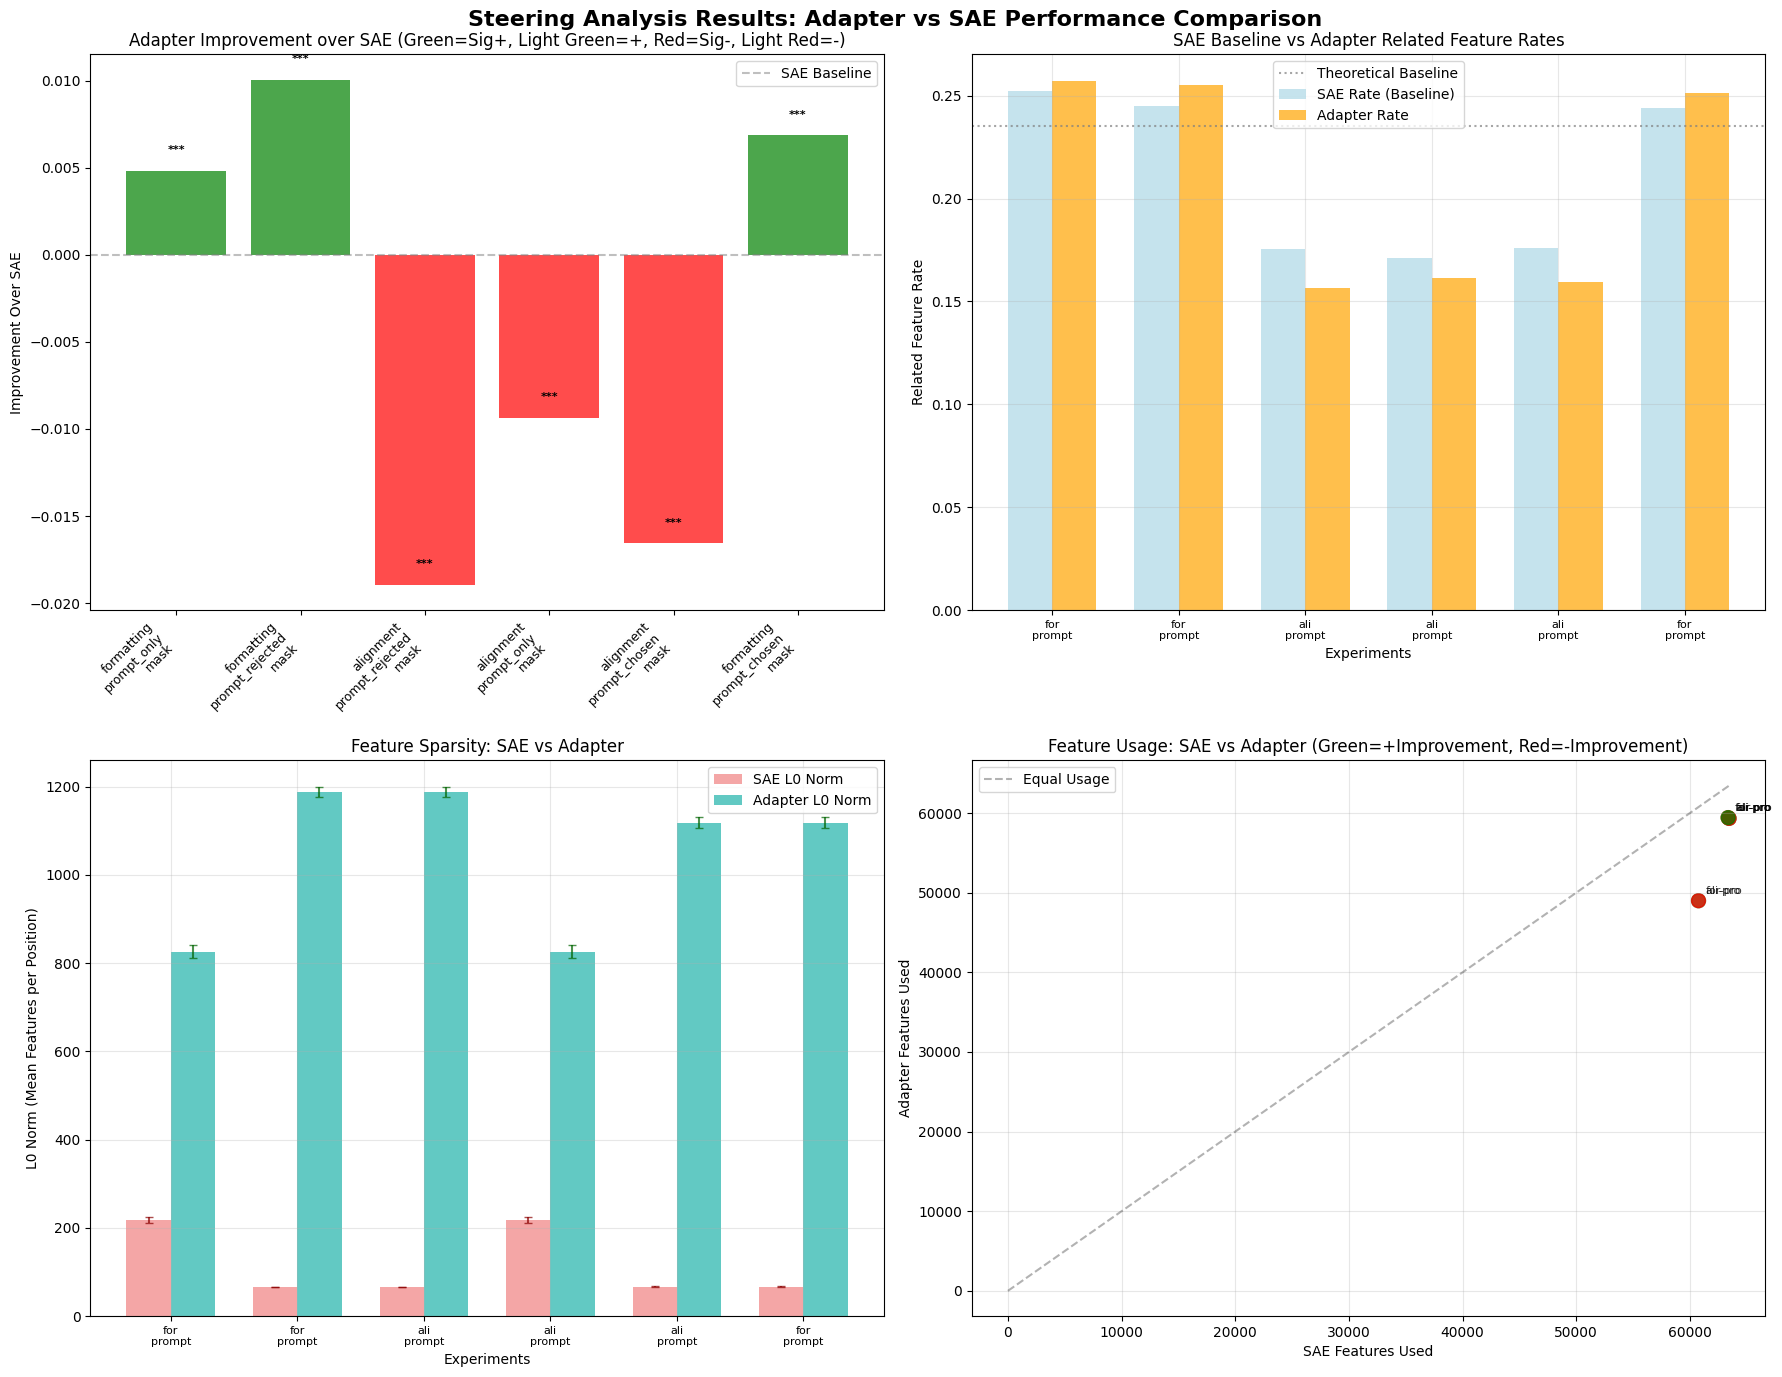


📈 STEERING ANALYSIS SUMMARY STATISTICS (Adapter vs SAE)
Individual Experiment Results:
  • Total experiments: 6
  • Modes: formatting, alignment
  • Response types: prompt_only, prompt_rejected, prompt_chosen
  • Experiments with positive improvement over SAE: 3/6
  • Statistically significant improvements over SAE: 6/6

Overall Statistics (Adapter vs SAE):
  • Mean improvement over SAE: -0.0038
  • Std improvement over SAE: 0.0127
  • Best improvement over SAE: 0.0101
  • Worst improvement over SAE: -0.0190

Overall Statistics (vs Theoretical Baseline for comparison):
  • Mean improvement over theoretical: 0.0038
  • Best improvement over theoretical: 0.0217

Baseline Comparison:
  • Mean theoretical baseline rate: 0.203 (20.3%)
  • Mean SAE baseline rate: 0.211 (21.1%)
  • Mean adapter rate: 0.207 (20.7%)

L0 Norm Comparison:
  • Mean SAE L0 norm: 117.10
  • Mean Adapter L0 norm: 1043.99
  • L0 difference (Adapter - SAE): 926.88

Feature Usage Comparison:
  • Mean SAE features used:

,Mode,Response,Ignore Mask,SAE Rate,Adapter Rate,Improvement,SAE L0,Adapter L0,Significance
0,formatting,prompt_only,True,0.2525,0.2573,0.0048,218.1489,825.4655,***
1,formatting,prompt_reje...,True,0.2451,0.2552,0.0101,66.1587,1188.1893,***
2,alignment,prompt_reje...,True,0.1753,0.1564,-0.0190,66.1587,1188.1893,***
3,alignment,prompt_only,True,0.1710,0.1616,-0.0093,218.1489,825.4655,***
4,alignment,prompt_chosen,True,0.1759,0.1593,-0.0166,67.0015,1118.3045,***
5,formatting,prompt_chosen,True,0.2443,0.2512,0.0069,67.0015,1118.3045,***


In [14]:
# Visualize Steering Performance (Adapter vs SAE)
if len(df) > 0:
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Steering Analysis Results: Adapter vs SAE Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Improvement Over SAE by Experiment
    ax1 = axes[0, 0]
    df_plot = df.copy()
    if len(df_plot) > 0:
        # Color by significance and direction (adapter vs SAE)
        colors = []
        for _, row in df_plot.iterrows():
            if row['adapter_vs_sae_sig'] != '' and row['improvement_over_sae'] > 0:
                colors.append('green')  # Significant positive
            elif row['improvement_over_sae'] > 0:
                colors.append('lightgreen')  # Positive but not significant
            elif row['adapter_vs_sae_sig'] != '':
                colors.append('red')  # Significant negative
            else:
                colors.append('lightcoral')  # Negative but not significant
        
        x_labels = [f"{row['mode']}\n{row['response_type']}\n{'mask' if row['ignore_mask'] else 'no-mask'}" 
                   for _, row in df_plot.iterrows()]
        
        bars = ax1.bar(range(len(df_plot)), df_plot['improvement_over_sae'], color=colors, alpha=0.7)
        ax1.set_xticks(range(len(df_plot)))
        ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        ax1.set_ylabel('Improvement Over SAE')
        ax1.set_title('Adapter Improvement over SAE (Green=Sig+, Light Green=+, Red=Sig-, Light Red=-)')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='SAE Baseline')
        ax1.legend()
        
        # Add significance annotations
        for i, (_, row) in enumerate(df_plot.iterrows()):
            if row['adapter_vs_sae_sig']:
                ax1.annotate(row['adapter_vs_sae_sig'], (i, row['improvement_over_sae'] + 0.001), 
                           ha='center', fontweight='bold', fontsize=8)
    
    # 2. SAE vs Adapter Rates Comparison
    ax2 = axes[0, 1]
    if len(df) > 0:
        x = np.arange(len(df))
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, df['sae_related_rate'], width, label='SAE Rate (Baseline)', 
                       alpha=0.7, color='lightblue')
        bars2 = ax2.bar(x + width/2, df['adapter_steering_related_rate'], width, label='Adapter Rate', 
                       alpha=0.7, color='orange')
        
        # Add theoretical baseline line for reference
        ax2.axhline(y=df['adapter_baseline_related_rate'].iloc[0] if len(df) > 0 else 0, 
                   color='gray', linestyle=':', alpha=0.7, label='Theoretical Baseline')
        
        ax2.set_xlabel('Experiments')
        ax2.set_ylabel('Related Feature Rate')
        ax2.set_title('SAE Baseline vs Adapter Related Feature Rates')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"{row['mode'][:3]}\n{row['response_type'][:6]}" 
                            for _, row in df.iterrows()], fontsize=8)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. L0 Norm Comparison (Adapter vs SAE)
    ax3 = axes[1, 0]
    if len(df) > 0:
        x = np.arange(len(df))
        width = 0.35
        
        bars1 = ax3.bar(x - width/2, df['sae_l0_norm_mean'], width, label='SAE L0 Norm', 
                       alpha=0.7, color='lightcoral')
        bars2 = ax3.bar(x + width/2, df['adapter_l0_norm_mean'], width, label='Adapter L0 Norm', 
                       alpha=0.7, color='lightseagreen')
        
        # Add error bars
        ax3.errorbar(x - width/2, df['sae_l0_norm_mean'], yerr=df['sae_l0_norm_stderr'], 
                    fmt='none', color='darkred', capsize=3, alpha=0.7)
        ax3.errorbar(x + width/2, df['adapter_l0_norm_mean'], yerr=df['adapter_l0_norm_stderr'], 
                    fmt='none', color='darkgreen', capsize=3, alpha=0.7)
        
        ax3.set_xlabel('Experiments')
        ax3.set_ylabel('L0 Norm (Mean Features per Position)')
        ax3.set_title('Feature Sparsity: SAE vs Adapter')
        ax3.set_xticks(x)
        ax3.set_xticklabels([f"{row['mode'][:3]}\n{row['response_type'][:6]}" 
                            for _, row in df.iterrows()], fontsize=8)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Total Features Used: SAE vs Adapter
    ax4 = axes[1, 1]
    if len(df) > 0:
        # Create scatter plot showing relationship between SAE and Adapter feature usage
        scatter_colors = ['green' if imp > 0 else 'red' for imp in df['improvement_over_sae']]
        scatter = ax4.scatter(df['sae_total_active_features'], df['adapter_total_steered_features'], 
                            c=scatter_colors, alpha=0.7, s=100)
        
        # Add diagonal line for reference (y=x)
        max_features = max(df['sae_total_active_features'].max(), df['adapter_total_steered_features'].max())
        ax4.plot([0, max_features], [0, max_features], 'k--', alpha=0.3, label='Equal Usage')
        
        # Add labels for each point
        for i, (_, row) in enumerate(df.iterrows()):
            ax4.annotate(f"{row['mode'][:3]}-{row['response_type'][:3]}", 
                        (row['sae_total_active_features'], row['adapter_total_steered_features']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
        
        ax4.set_xlabel('SAE Features Used')
        ax4.set_ylabel('Adapter Features Used')
        ax4.set_title('Feature Usage: SAE vs Adapter (Green=+Improvement, Red=-Improvement)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📈 STEERING ANALYSIS SUMMARY STATISTICS (Adapter vs SAE)")
    print("=" * 70)
    
    if len(df) > 0:
        print(f"Individual Experiment Results:")
        print(f"  • Total experiments: {len(df)}")
        print(f"  • Modes: {', '.join(df['mode'].unique())}")
        print(f"  • Response types: {', '.join(df['response_type'].unique())}")
        print(f"  • Experiments with positive improvement over SAE: {(df['improvement_over_sae'] > 0).sum()}/{len(df)}")
        print(f"  • Statistically significant improvements over SAE: {(df['adapter_vs_sae_sig'] != '').sum()}/{len(df)}")
        
        print(f"\nOverall Statistics (Adapter vs SAE):")
        print(f"  • Mean improvement over SAE: {df['improvement_over_sae'].mean():.4f}")
        print(f"  • Std improvement over SAE: {df['improvement_over_sae'].std():.4f}")
        print(f"  • Best improvement over SAE: {df['improvement_over_sae'].max():.4f}")
        print(f"  • Worst improvement over SAE: {df['improvement_over_sae'].min():.4f}")
        
        print(f"\nOverall Statistics (vs Theoretical Baseline for comparison):")
        print(f"  • Mean improvement over theoretical: {df['adapter_improvement_over_baseline'].mean():.4f}")
        print(f"  • Best improvement over theoretical: {df['adapter_improvement_over_baseline'].max():.4f}")
        
        print(f"\nBaseline Comparison:")
        print(f"  • Mean theoretical baseline rate: {df['adapter_baseline_related_rate'].mean():.3f} ({df['adapter_baseline_related_rate'].mean()*100:.1f}%)")
        print(f"  • Mean SAE baseline rate: {df['sae_related_rate'].mean():.3f} ({df['sae_related_rate'].mean()*100:.1f}%)")
        print(f"  • Mean adapter rate: {df['adapter_steering_related_rate'].mean():.3f} ({df['adapter_steering_related_rate'].mean()*100:.1f}%)")
        
        print(f"\nL0 Norm Comparison:")
        print(f"  • Mean SAE L0 norm: {df['sae_l0_norm_mean'].mean():.2f}")
        print(f"  • Mean Adapter L0 norm: {df['adapter_l0_norm_mean'].mean():.2f}")
        print(f"  • L0 difference (Adapter - SAE): {(df['adapter_l0_norm_mean'] - df['sae_l0_norm_mean']).mean():.2f}")
        
        print(f"\nFeature Usage Comparison:")
        print(f"  • Mean SAE features used: {df['sae_total_active_features'].mean():.1f}")
        print(f"  • Mean Adapter features used: {df['adapter_total_steered_features'].mean():.1f}")
        print(f"  • Mean SAE related features: {df['sae_related_active'].mean():.1f}")
        print(f"  • Mean Adapter related features: {df['adapter_related_steered'].mean():.1f}")
        
        # Show a detailed comparison table
        print(f"\n📋 EXPERIMENT COMPARISON TABLE:")
        comparison_summary = df[['mode', 'response_type', 'ignore_mask', 
                               'sae_related_rate', 'adapter_steering_related_rate', 'improvement_over_sae',
                               'sae_l0_norm_mean', 'adapter_l0_norm_mean', 'adapter_vs_sae_sig']].copy()
        comparison_summary.columns = ['Mode', 'Response', 'Ignore Mask', 'SAE Rate', 'Adapter Rate', 
                                    'Improvement', 'SAE L0', 'Adapter L0', 'Significance']
        comparison_summary = comparison_summary.round(4)
        display(comparison_summary)
    
else:
    print("No data available for visualization.")

In [15]:
# Export Steering Analysis Results (Adapter vs SAE)
if len(df) > 0:
    # Save comprehensive results
    output_dir = Path('../outputs/feature_classification/analysis')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Export detailed results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Full results with all columns
    full_results_file = output_dir / f'steering_analysis_adapter_vs_sae_detailed_{timestamp}.csv'
    df.to_csv(full_results_file, index=False)
    
    # Summary table (adapter vs SAE baseline)
    summary_file = output_dir / f'steering_analysis_adapter_vs_sae_summary_{timestamp}.csv'
    final_table.to_csv(summary_file, index=False)
    
    # JSON summary for programmatic access
    json_summary = {
        'timestamp': timestamp,
        'analysis_type': 'adapter_vs_sae',
        'total_experiments': len(df),
        'modes': df['mode'].value_counts().to_dict(),
        'response_types': df['response_type'].value_counts().to_dict(),
        'ignore_mask_usage': df['ignore_mask'].value_counts().to_dict(),
        'positive_improvements_vs_sae': (df['improvement_over_sae'] > 0).sum(),
        'significant_improvements_vs_sae': (df['adapter_vs_sae_sig'] != '').sum(),
        'positive_improvements_vs_theoretical': (df['adapter_improvement_over_baseline'] > 0).sum(),
        'significant_improvements_vs_theoretical': (df['improvement_sig'] != '').sum(),
        'mean_improvement_vs_sae': float(df['improvement_over_sae'].mean()),
        'mean_improvement_vs_theoretical': float(df['adapter_improvement_over_baseline'].mean()),
        'best_experiment_vs_sae': {
            'improvement': float(df['improvement_over_sae'].max()),
            'mode': df.loc[df['improvement_over_sae'].idxmax(), 'mode'],
            'response_type': df.loc[df['improvement_over_sae'].idxmax(), 'response_type'],
            'ignore_mask': bool(df.loc[df['improvement_over_sae'].idxmax(), 'ignore_mask']),
            'adapter_rate': float(df.loc[df['improvement_over_sae'].idxmax(), 'adapter_steering_related_rate']),
            'sae_rate': float(df.loc[df['improvement_over_sae'].idxmax(), 'sae_related_rate']),
            'theoretical_rate': float(df.loc[df['improvement_over_sae'].idxmax(), 'adapter_baseline_related_rate'])
        },
        'baseline_comparison': {
            'mean_theoretical_baseline': float(df['adapter_baseline_related_rate'].mean()),
            'mean_sae_baseline': float(df['sae_related_rate'].mean()),
            'mean_adapter_rate': float(df['adapter_steering_related_rate'].mean()),
            'sae_vs_theoretical_difference': float(df['sae_related_rate'].mean() - df['adapter_baseline_related_rate'].mean())
        },
        'l0_norm_comparison': {
            'mean_sae_l0': float(df['sae_l0_norm_mean'].mean()),
            'mean_adapter_l0': float(df['adapter_l0_norm_mean'].mean()),
            'l0_difference': float((df['adapter_l0_norm_mean'] - df['sae_l0_norm_mean']).mean()),
            'sae_l0_range': [float(df['sae_l0_norm_mean'].min()), float(df['sae_l0_norm_mean'].max())],
            'adapter_l0_range': [float(df['adapter_l0_norm_mean'].min()), float(df['adapter_l0_norm_mean'].max())]
        },
        'feature_usage_comparison': {
            'mean_sae_features_used': float(df['sae_total_active_features'].mean()),
            'mean_adapter_features_used': float(df['adapter_total_steered_features'].mean()),
            'mean_sae_related_features': float(df['sae_related_active'].mean()),
            'mean_adapter_related_features': float(df['adapter_related_steered'].mean()),
            'feature_usage_difference': float((df['adapter_total_steered_features'] - df['sae_total_active_features']).mean())
        }
    }
    
    json_file = output_dir / f'steering_analysis_adapter_vs_sae_summary_{timestamp}.json'
    with json_file.open('w') as f:
        json.dump(json_summary, f, indent=2, default=str)
    
    print(f"\n💾 STEERING ANALYSIS RESULTS EXPORTED (Adapter vs SAE)")
    print(f"Full results: {full_results_file}")
    print(f"Summary table: {summary_file}")
    print(f"JSON summary: {json_file}")
    
    # Display key findings
    print(f"\n🎯 KEY FINDINGS (Adapter vs SAE Baseline):")
    best_exp = json_summary['best_experiment_vs_sae']
    print(f"Best Performance: {best_exp['improvement']:.4f} improvement over SAE")
    print(f"  • Mode: {best_exp['mode']}")
    print(f"  • Response: {best_exp['response_type']}")
    print(f"  • Ignore mask: {best_exp['ignore_mask']}")
    print(f"  • Adapter rate: {best_exp['adapter_rate']:.3f} ({best_exp['adapter_rate']*100:.1f}%)")
    print(f"  • SAE rate (baseline): {best_exp['sae_rate']:.3f} ({best_exp['sae_rate']*100:.1f}%)")
    print(f"  • Theoretical rate: {best_exp['theoretical_rate']:.3f} ({best_exp['theoretical_rate']*100:.1f}%)")
    
    print(f"\nBaseline Comparison Summary:")
    baseline_comp = json_summary['baseline_comparison']
    print(f"  • Theoretical baseline: {baseline_comp['mean_theoretical_baseline']:.3f} ({baseline_comp['mean_theoretical_baseline']*100:.1f}%)")
    print(f"  • SAE baseline: {baseline_comp['mean_sae_baseline']:.3f} ({baseline_comp['mean_sae_baseline']*100:.1f}%)")
    print(f"  • Adapter performance: {baseline_comp['mean_adapter_rate']:.3f} ({baseline_comp['mean_adapter_rate']*100:.1f}%)")
    print(f"  • SAE vs Theoretical difference: {baseline_comp['sae_vs_theoretical_difference']:.4f}")
    
    print(f"\nOverall Summary (Adapter vs SAE):")
    print(f"  • {json_summary['positive_improvements_vs_sae']}/{json_summary['total_experiments']} experiments show positive improvement over SAE")
    print(f"  • {json_summary['significant_improvements_vs_sae']}/{json_summary['total_experiments']} experiments are statistically significant vs SAE")
    print(f"  • Mean improvement over SAE: {json_summary['mean_improvement_vs_sae']:.4f}")
    
    print(f"\nComparison with Theoretical Baseline:")
    print(f"  • {json_summary['positive_improvements_vs_theoretical']}/{json_summary['total_experiments']} experiments show positive improvement over theoretical")
    print(f"  • {json_summary['significant_improvements_vs_theoretical']}/{json_summary['total_experiments']} experiments are statistically significant vs theoretical")
    print(f"  • Mean improvement over theoretical: {json_summary['mean_improvement_vs_theoretical']:.4f}")
    
    print(f"\nSparsity Analysis:")
    l0_comp = json_summary['l0_norm_comparison']
    print(f"  • Mean SAE L0 norm: {l0_comp['mean_sae_l0']:.2f} features per position")
    print(f"  • Mean Adapter L0 norm: {l0_comp['mean_adapter_l0']:.2f} features per position")
    print(f"  • L0 difference (Adapter - SAE): {l0_comp['l0_difference']:.2f} features per position")
    
    print(f"\nFeature Usage Analysis:")
    feature_comp = json_summary['feature_usage_comparison']
    print(f"  • Mean SAE features used: {feature_comp['mean_sae_features_used']:.1f}")
    print(f"  • Mean Adapter features used: {feature_comp['mean_adapter_features_used']:.1f}")
    print(f"  • Difference in total features used: {feature_comp['feature_usage_difference']:.1f}")
    
else:
    print("\n⚠️  No results to export. Run steering analysis experiments first.")


💾 STEERING ANALYSIS RESULTS EXPORTED (Adapter vs SAE)
Full results: ../outputs/feature_classification/analysis/steering_analysis_adapter_vs_sae_detailed_20250821_030143.csv
Summary table: ../outputs/feature_classification/analysis/steering_analysis_adapter_vs_sae_summary_20250821_030143.csv
JSON summary: ../outputs/feature_classification/analysis/steering_analysis_adapter_vs_sae_summary_20250821_030143.json

🎯 KEY FINDINGS (Adapter vs SAE Baseline):
Best Performance: 0.0101 improvement over SAE
  • Mode: formatting
  • Response: prompt_rejected
  • Ignore mask: True
  • Adapter rate: 0.255 (25.5%)
  • SAE rate (baseline): 0.245 (24.5%)
  • Theoretical rate: 0.236 (23.6%)

Baseline Comparison Summary:
  • Theoretical baseline: 0.203 (20.3%)
  • SAE baseline: 0.211 (21.1%)
  • Adapter performance: 0.207 (20.7%)
  • SAE vs Theoretical difference: 0.0076

Overall Summary (Adapter vs SAE):
  • 3/6 experiments show positive improvement over SAE
  • 6/6 experiments are statistically signific

In [19]:
# Create LaTeX Table for Report (Adapter vs SAE Baseline)
if len(df) > 0:
    # Function to format labels nicely
    def format_mode_label(mode):
        """Format mode labels for display."""
        if mode == 'alignment':
            return 'Alignment'
        elif mode == 'formatting':
            return 'Style'
        else:
            return mode.title()
    
    def format_response_label(response_type):
        """Format response type labels for display."""
        if response_type == 'prompt_only':
            return 'Prompt Only'
        elif response_type == 'prompt_chosen':
            return 'Prompt + Chosen'
        elif response_type == 'prompt_rejected':
            return 'Prompt + Rejected'
        else:
            return response_type.replace('_', ' ').title()
    
    def format_pvalue(p_value):
        """Format p-value for display with higher precision."""
        if p_value is None or pd.isna(p_value):
            return 'N/A'
        elif p_value < 1e-15:
            return '$<10^{-15}$'
        elif p_value < 1e-10:
            return f'${p_value:.2e}$'
        elif p_value < 1e-6:
            return f'${p_value:.1e}$'
        elif p_value < 0.0001:
            return f'${p_value:.6f}$'
        elif p_value < 0.001:
            return f'${p_value:.4f}$'
        elif p_value < 0.01:
            return f'${p_value:.3f}$'
        else:
            return f'${p_value:.3f}$'
    
    def calculate_sae_se(sae_rate, n_positions):
        """Calculate standard error for SAE baseline rate."""
        if n_positions <= 0:
            return None
        return np.sqrt(sae_rate * (1 - sae_rate) / n_positions)
    
    def calculate_improvement_se_vs_sae(sae_rate, adapter_rate, n_positions):
        """Calculate standard error for improvement over SAE."""
        if n_positions <= 0:
            return None
        sae_var = sae_rate * (1 - sae_rate) / n_positions
        adapter_var = adapter_rate * (1 - adapter_rate) / n_positions
        se_diff = np.sqrt(sae_var + adapter_var)
        return se_diff
    
    # First, let's examine the data to understand the new baseline comparison
    print("🔍 DATA INSPECTION (Adapter vs SAE):")
    print("=" * 70)
    print("Sample sizes and baseline comparison:")
    inspection_data = df[['mode', 'response_type', 'adapter_total_positions_analyzed', 
                         'adapter_baseline_related_rate', 'sae_related_rate', 
                         'adapter_steering_related_rate', 'improvement_over_sae']].copy()
    print(inspection_data.to_string(index=False))
    
    # Debug the statistical calculations for adapter vs SAE
    print(f"\nDetailed Statistical Analysis (Adapter vs SAE using Binomial Test):")
    for _, row in df.iterrows():
        improvement = row['improvement_over_sae']
        n = row['adapter_total_positions_analyzed']
        sae_rate = row['sae_related_rate']
        adapter_rate = row['adapter_steering_related_rate']
        
        # Calculate what was tested
        adapter_successes = int(round(adapter_rate * n))
        expected_successes_sae = sae_rate * n
        
        print(f"\n  {row['mode']}-{row['response_type']}:")
        print(f"    Improvement over SAE: {improvement:.8f}")
        print(f"    Sample size: {n:,}")
        print(f"    SAE baseline rate: {sae_rate:.6f} (expected: {expected_successes_sae:.0f} successes)")
        print(f"    Adapter rate: {adapter_rate:.6f} (observed: {adapter_successes} successes)")
        print(f"    Difference: {adapter_successes - expected_successes_sae:.0f} successes")
        
        # Check if p-value column exists
        if 'adapter_vs_sae_pvalue' in df.columns:
            print(f"    P-value (binomial vs SAE): {row['adapter_vs_sae_pvalue']:.2e}")
        else:
            print(f"    P-value: Not calculated yet (run statistical tests cell)")
    
    if 'adapter_vs_sae_pvalue' in df.columns:
        print(f"\nP-values range (vs SAE): {df['adapter_vs_sae_pvalue'].min():.2e} to {df['adapter_vs_sae_pvalue'].max():.2e}")
    print(f"Improvements range (vs SAE): {df['improvement_over_sae'].min():.6f} to {df['improvement_over_sae'].max():.6f}")
    
    # Create the LaTeX table with booktabs and multicolumn formatting
    print(f"\n📋 CREATING FANCY LATEX TABLE WITH BOOKTABS (Adapter vs SAE Baseline):")
    print("=" * 100)
    
    print(f"\n📄 LATEX TABLE CODE:")
    print("=" * 100)
    
    # Create a fancy booktabs LaTeX table with multicolumn headers and alternating colors
    latex_lines = []
    
    # Table header with packages
    latex_lines.append("% Required packages: \\usepackage{booktabs}")
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append("\\caption{Steering Analysis Results: Adapter performance vs SAE baseline. The SAE baseline shows the natural rate at which the unmodified SAE activates related features for each specific response type. Relative change shows the percentage difference between adapter steering and the SAE natural rate. Improvement column: $\\checkmark$ indicates positive change, $\\times$ indicates negative change.}")
    latex_lines.append("\\label{tab:steering_vs_sae_results}")
    latex_lines.append("\\begin{tabular}{ccccc}")
    latex_lines.append("\\toprule")
    latex_lines.append("Feature Type & Data & SAE Baseline (\\%) & Relative Change (\\%) & Improvement \\\\")
    latex_lines.append("\\midrule")
    
    # Process data by mode groups
    row_counter = 0  # Keep track of row numbers for alternating colors
    
    for mode in sorted(df['mode'].unique()):
        mode_data = df[df['mode'] == mode].copy()
        mode_data = mode_data.sort_values('response_type')
        
        mode_label = format_mode_label(mode)
        
        # Add response type rows with mode in first column
        for idx, (_, row) in enumerate(mode_data.iterrows()):
            # Calculate SAE baseline and its standard error for THIS specific row
            sae_rate = row['sae_related_rate']  # Use the specific SAE rate for this response type
            n_positions = row['adapter_total_positions_analyzed']
            sae_se = calculate_sae_se(sae_rate, n_positions)
            
            if sae_se is not None:
                sae_baseline_formatted = f"{sae_rate*100:.2f} $\\pm$ {sae_se*100:.2f}"
            else:
                sae_baseline_formatted = f"{sae_rate*100:.2f}"
            
            # Calculate improvement and its standard error
            improvement_se = calculate_improvement_se_vs_sae(
                sae_rate, 
                row['adapter_steering_related_rate'], 
                n_positions
            )
            
            # Calculate relative improvement as a percentage
            relative_improvement = row['improvement_over_sae'] / sae_rate if sae_rate > 0 else 0
            
            if improvement_se is not None and sae_rate > 0:
                relative_improvement_se = improvement_se / sae_rate
                improvement_formatted = f"{relative_improvement*100:.2f} $\\pm$ {relative_improvement_se*100:.2f}"
            else:
                improvement_formatted = f"{relative_improvement*100:.2f}"
            
            response_label = format_response_label(row['response_type'])
            improvement_symbol = '$\\checkmark$' if row['improvement_over_sae'] > 0 else '$\\times$'
            
            # Show mode label only in first row of each group
            mode_display = mode_label if idx == 0 else ""
            
            # Each row gets its own SAE baseline (no empty cells)
            latex_lines.append(f"{mode_display} & {response_label} & {sae_baseline_formatted} & {improvement_formatted} & {improvement_symbol} \\\\")
            
            row_counter += 1
        
        # Add midrule between modes (only if not the last mode)
        if mode != sorted(df['mode'].unique())[-1]:
            latex_lines.append("\\midrule")
    
    # Table footer
    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{table}")
    
    latex_table = "\n".join(latex_lines)
    
    print(latex_table)
    
    # Save to file
    output_dir = Path('../outputs/feature_classification/analysis')
    latex_file = output_dir / f'steering_vs_sae_latex_table_{datetime.now().strftime("%Y%m%d_%H%M%S")}.tex'
    with latex_file.open('w') as f:
        f.write(latex_table)
    
    print(f"\n💾 LaTeX table saved to: {latex_file}")
    
    # Also create a comparison table showing theoretical vs SAE baselines
    print(f"\n📄 COMPARISON TABLE (Theoretical vs SAE vs Adapter):")
    print("=" * 100)
    
    comparison_latex_lines = []
    comparison_latex_lines.append("% Comparison table showing all three rates")
    comparison_latex_lines.append("\\begin{table}[htbp]")
    comparison_latex_lines.append("\\centering")
    comparison_latex_lines.append("\\caption{Baseline Comparison: Theoretical vs SAE vs Adapter Rates}")
    comparison_latex_lines.append("\\label{tab:baseline_comparison}")
    comparison_latex_lines.append("\\begin{tabular}{cccccc}")
    comparison_latex_lines.append("\\toprule")
    comparison_latex_lines.append("Feature Type & Data & Theoretical (\\%) & SAE (\\%) & Adapter (\\%) & Best Improvement \\\\")
    comparison_latex_lines.append("\\midrule")
    
    for mode in sorted(df['mode'].unique()):
        mode_data = df[df['mode'] == mode].copy()
        mode_data = mode_data.sort_values('response_type')
        mode_label = format_mode_label(mode)
        
        for idx, (_, row) in enumerate(mode_data.iterrows()):
            response_label = format_response_label(row['response_type'])
            
            theoretical_rate = f"{row['adapter_baseline_related_rate']*100:.1f}"
            sae_rate = f"{row['sae_related_rate']*100:.1f}"
            adapter_rate = f"{row['adapter_steering_related_rate']*100:.1f}"
            
            # Determine which improvement is better
            improvement_vs_theoretical = row['adapter_improvement_over_baseline']
            improvement_vs_sae = row['improvement_over_sae']
            
            if abs(improvement_vs_sae) > abs(improvement_vs_theoretical):
                best_improvement = f"vs SAE: {improvement_vs_sae:.3f}"
            else:
                best_improvement = f"vs Theo: {improvement_vs_theoretical:.3f}"
            
            # Show mode only in first row of group
            mode_display = mode_label if idx == 0 else ""
            
            comparison_latex_lines.append(f"{mode_display} & {response_label} & {theoretical_rate} & {sae_rate} & {adapter_rate} & {best_improvement} \\\\")
        
        if mode != sorted(df['mode'].unique())[-1]:
            comparison_latex_lines.append("\\midrule")
    
    comparison_latex_lines.append("\\bottomrule")
    comparison_latex_lines.append("\\end{tabular}")
    comparison_latex_lines.append("\\end{table}")
    
    comparison_latex_table = "\n".join(comparison_latex_lines)
    print(comparison_latex_table)
    
    # Save comparison table
    comparison_latex_file = output_dir / f'baseline_comparison_latex_table_{datetime.now().strftime("%Y%m%d_%H%M%S")}.tex'
    with comparison_latex_file.open('w') as f:
        f.write(comparison_latex_table)
    
    print(f"\n💾 Comparison LaTeX table saved to: {comparison_latex_file}")

else:
    print("\n⚠️  No results available for LaTeX table generation.")

# Show the main table
print("\n🎯 FINAL LATEX TABLE:")
print("=" * 50)
if 'latex_table' in locals():
    print(latex_table)
else:
    print("LaTeX table not generated - check if data is available.")

🔍 DATA INSPECTION (Adapter vs SAE):
Sample sizes and baseline comparison:
      mode   response_type  adapter_total_positions_analyzed  adapter_baseline_related_rate  sae_related_rate  adapter_steering_related_rate  improvement_over_sae
formatting     prompt_only                            467682                       0.235538          0.252453                       0.257280              0.004827
formatting prompt_rejected                           1496692                       0.235538          0.245116                       0.255189              0.010073
 alignment prompt_rejected                           1496692                       0.170528          0.175337                       0.156384             -0.018954
 alignment     prompt_only                            467682                       0.170528          0.170957                       0.161608             -0.009349
 alignment   prompt_chosen                           1445875                       0.170528          0.175866  